In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Dataset

In [3]:
#Abbiamo 1797 campioni, ciascuno 8x8. Ogni immagine è organizzata come un vettore di 64 pixel
digits_dataset = load_digits()

print(digits_dataset.data.shape)

(1797, 64)


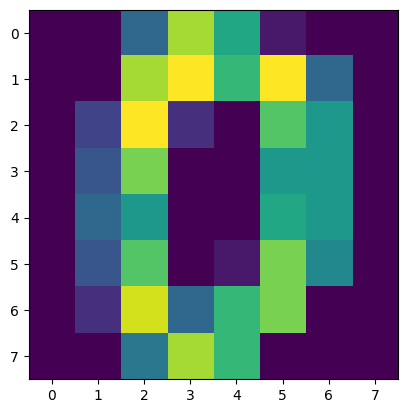

In [4]:
from matplotlib import pyplot as plt
#ogni riga è una immagine. Vediamo un esempio
img1 = digits_dataset.data[0]
#facciamo il reshape del vettore di 64 elementi in 8x8
img1 = np.reshape(img1, (8,8))
plt.imshow(img1)


In [5]:
#essendo ogni riga una immagine allora prendo le prime 1000 come training set, 350 come validation set e il resto come test set
training_data = digits_dataset.data[0:1000].astype(np.float32)
validation_data = digits_dataset.data[1000:1350].astype(np.float32)
test_data = digits_dataset.data[1350:].astype(np.float32)

Non alleneremo la rete dandole tutti i dati, ma batch dopo batch. Creiamo quindi un DataLoader che semplicemente dividerà i dati in batch da 64 immagini (dopo averli mischiati) e ci restituirà, quando richiesto, un batch alla volta.

In [6]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Model

Creiamo il CausalConv1D

In [7]:
class CausalConv1d(nn.Module):

  def __init__(self, num_canali_input, num_canali_output, kernel_size, dilation, A=False, **kwargs):
    super(CausalConv1d, self).__init__()

    self.kernel_size = kernel_size
    self.dilation = dilation
    self.A = A

    self.padding = (kernel_size-1)*dilation +A*1

    self.conv1d = torch.nn.Conv1d(num_canali_input, num_canali_output, kernel_size, stride=1,padding=0, dilation=dilation, **kwargs)

  def forward(self, x):
    #la funzione concatena self.padding zeri a sinistra di x
    x = torch.nn.functional.pad(x, (self.padding, 0))
    conv1d_out = self.conv1d(x)
    if self.A:
        return conv1d_out[:, :, : -1]
    else:
        return conv1d_out

In [8]:
kernel = 7
num_kernels = 256
num_outputs = 17

net = nn.Sequential(
    CausalConv1d(num_canali_input=1, num_canali_output=num_kernels, kernel_size=kernel, dilation=1,A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(num_canali_input=num_kernels, num_canali_output=num_kernels, kernel_size=kernel,dilation=2, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(num_canali_input=num_kernels, num_canali_output=num_kernels, kernel_size=kernel,dilation=4, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(num_canali_input=num_kernels, num_canali_output=num_outputs, kernel_size=kernel, dilation=8, A=False, bias=True))


In [21]:
class ARM(nn.Module):
    def __init__(self, net, dimensione_input, num_output):
        super(ARM, self).__init__()

        self.net = net
        self.num_output = num_output
        self.dimensione_input = dimensione_input

    def forward(self, x):
        #faccio passare il batch attraverso la rete. Alla fine otterrò (N,17,64) con N numero immagini
        h = self.net(x)
        #per semplicità, voglio per ognuna delle N immagini e per ognuno dei suoi 64 pixel il vettore di probabilità
        h = h.permute(0,2,1) # adesso ho (N,64,17)
        #per ogni pixel converto i 17 valori in probabilità
        p = torch.softmax(h,2)

        #calcolo la MLE
        EPS = 1.e-5
        #serve per selezionare un valore dal vettore probabilità
        x_one_hot = F.one_hot(x.long(), num_classes=self.num_output).squeeze()
        #calcolo i logaritmi di ogni probabilità estratta
        log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
        vector_of_probabilities_for_image = torch.sum(log_p, dim=-1) #contiene le 64 probabilità selezionate
        #per ogni immagine abbiamo il vettore di probabilità. Sommiamole e cambiamo segno
        mle_per_image = -vector_of_probabilities_for_image.sum(-1)
        #una mle di aggregazione
        mle_batch = mle_per_image.sum()

        return mle_batch

    def sample(self):
        x_new = torch.zeros((1,self.dimensione_input))
        #per ogni dimensione x1,x2,....,x64
        for xi in range(self.dimensione_input):
            #do alla rete il vettore x_new
            h = self.net(x_new.unsqueeze(1))
            h = h.permute(0, 2, 1)
            #genero probabilità
            p = torch.softmax(h, 2)

            #creo una distribuzione categorica usando solo le probabilità della dimensione xi
            x_new_xi = torch.multinomial(p[:, xi, :], num_samples=1)
            x_new[:, xi] = x_new_xi[:,0]

        return x_new

In [23]:
model = ARM(net, dimensione_input=64, num_output=num_outputs)

#Training

In [10]:
learning_rate = 0.002
#i parametri che l'optimizer deve ottimizzare sono tutti quelli del modello
parameters_to_optimize = [p for p in model.parameters() if p.requires_grad == True]

optimizer = torch.optim.Adamax(parameters_to_optimize, lr=learning_rate)

In [ ]:
import copy

number_of_epochs = 1000

#qui salvo il migliore modello, ossia quello che ha la loss sulla validazione migliore
best_model = model
best_validation_loss = 1000000

patience = 0
max_patience = 20

for epoch in range(number_of_epochs):
  model.train()
  print("Epoca "+str(epoch)+" _____________________________________________________________________")

  for index_batch, batch in enumerate(training_loader):
    #il batch ha shape 64x64. Portiamolo in (64,1,64), ossia 64 immagini ciascuna con
    # un canale e 64 pixel
    batch = batch.unsqueeze(1)
    #ottengo la loss sul batch corrente
    loss = model.forward(batch)

    #calcolo le derivate parziali della loss rispetto ogni parametro
    loss.backward()

    #adesso ogni parametro ha in .grad il gradiente. Aggiorno il suo valore
    optimizer.step()

    #resetto il .grad di ogni parametro (altrimenti sommo quello attuale al successivo che calcoleremo nell'epoca dopo)
    optimizer.zero_grad()

    print("   Loss: ", loss)

  #alla fine di ogni epoca, valuto come si comporta la loss col validation set
  print("   ___________________________")
  model.eval()
  validation_loss = 0
  N = 0
  for index_batch, batch in enumerate(validation_loader):
    batch = batch.unsqueeze(1)
    loss_i = model.forward(batch)
    validation_loss = validation_loss + loss_i
    N = N +  batch.shape[0]

  validation_loss = validation_loss/N
  print("   Loss media validation: "+str(validation_loss))

  #se tale modello ha una loss migliore di quella attualmente migliore..
  if validation_loss < best_validation_loss:
    patience = 0
    best_validation_loss = validation_loss
    print("   la loss risulta essere migliore")
    best_model = copy.deepcopy(model)
  else:
    print("   patience= "+ str(patience+1))
    patience = patience + 1
  
  if patience > max_patience:
    print("")
    print("Patience massimo superato. Fine del training")
    break






# Synthetic data generation

In [ ]:
#creo vettore di input
new_data = model.sample()